# Predicting Rental Profit 

## 1. Introduction

The objective of my project is to provide guidance to purchase a rental property as investment. This notebook demonstrates how to predict rental profit, with a subset of listings on zillow.com in the city of Philadelphia. The preliminary analysis of this small dataset showcases the feasibility of the project. The planned final product is a website showing estimated rental profit for all active sales listing in several major cities on zillow.com, and make recommendations based on user's preference.

## 2. Packages

In [369]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## 3. Data Collection

- Write the list of zipcode in Philly into a file as preparation for scraper

In [3]:
zip_list = []
with open('philly_zipcode','w') as f:
    for x in range(19102, 19155):
        zip_list.append(x)
        f.write(str(x)+'\n')

- Run scraper code to collect all data files
- Listings in each zipcode area are in one file

In [40]:
f_list = [line.rstrip('\n') for line in open('Data/file_list')]
f_list_rent = f_list[1:50]
f_list_sale = f_list[50:]

- Read sales data

In [341]:
df_from_each_file_sale = (pd.read_csv('Data/'+str(i)) for i in f_list_sale)
sale_data = pd.concat(df_from_each_file_sale, ignore_index=True)
sale_data.head(3)

,title,address,city,state,postal_code,price,bedroom,bathroom,area,lot_size,year_built,home_type,tax_assessed_value,url
0,House for sale,50 S 16th St UNIT 4604,Philadelphia,PA,19102,"$11,500,000",2.0,4.0,5550.0,-1.0,2007,SINGLE_FAMILY,7800000.0,https://www.zillow.com/homedetails/50-S-16th-S...
1,Condo for sale,111 S 15th St PENTHOUSE P310,Philadelphia,PA,19102,"$549,000",2.0,2.0,1062.0,-1.0,1900,CONDO,407600.0,https://www.zillow.com/homedetails/111-S-15th-...
2,Condo for sale,50 S 16th St UNIT 5105,Philadelphia,PA,19102,"$1,435,000",3.0,4.0,1722.0,-1.0,2016,CONDO,1170600.0,https://www.zillow.com/homedetails/50-S-16th-S...


In [342]:
df_from_each_file_rent = (pd.read_csv('Data/'+str(i)) for i in f_list_rent)
rent_data = pd.concat(df_from_each_file_rent, ignore_index=True)
rent_data = rent_data.dropna(subset = ['price'])
rent_data.head(3)

,title,address,city,state,postal_code,price,bedroom,bathroom,area,year_built,lot_size,home_type
0,Apartment for rent,201-50 S 15th St # 606,Philadelphia,PA,19102,"$1,365/mo",0.0,1.0,1100.0,-1,-1.0,APARTMENT
1,Apartment for rent,1429 Spruce St APT 2M,Philadelphia,PA,19102,"$1,150/mo",0.0,1.0,1100.0,-1,-1.0,MULTI_FAMILY
2,Apartment for rent,260 S 16th St APT 2F,Philadelphia,PA,19102,"$2,500/mo",1.0,1.0,900.0,1860,-1.0,APARTMENT


## 4. Data Preprocessing


- Rental Listings are used for building a predictive model
- Rental listings that are off market are dropped
- Missing values in the features: bedroom, bathroom, area, and year are filled with median, and the missing lot_size is filled with area

In [ ]:
rent_data = rent_data[~rent_data['title'].str.contains('Off market')]
rent_data['bedroom'] = rent_data['bedroom'].fillna((rent_data['bedroom'].median()))
rent_data['bathroom'] = rent_data['bathroom'].fillna((rent_data['bathroom'].median()))
rent_data['area'] = rent_data['area'].fillna((rent_data['area'].median()))
rent_data['year_built'] = rent_data['year_built'].fillna((rent_data['year_built'].median()))
rent_data['lot_size'] = rent_data['lot_size'].fillna((rent_data['area']))
rent_select = rent_data[['bedroom', 'bathroom', 'area','postal_code','year_built','home_type','price']]

- zipcode and home type are one-hot encoded

In [238]:
zip_dummy = pd.get_dummies(rent_select['postal_code'])
home_type_dummy = pd.get_dummies(rent_select['home_type'])
X_rent = pd.concat([rent_select, zip_dummy, home_type_dummy], axis=1)
X_rent = X_rent.drop(columns = ['home_type','postal_code'])

- year built feature shows -1 when the data is missing from the website, this can introduce bias
- replace the -1 value with median

In [247]:
median_year = np.median(X_rent['year_built'][X_rent['year_built']>-1])
X_rent['year_built'][X_rent['year_built']<0] = median_year

In [343]:
X_rent.head(3)

,bedroom,bathroom,area,year_built,19102,19103,19104,19106,19107,19111,...,95123,95124,95126,95127,95240,APARTMENT,CONDO,MULTI_FAMILY,SINGLE_FAMILY,TOWNHOUSE
0,0.0,1.0,1100.0,1930,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0.0,1.0,1100.0,1930,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1.0,900.0,1860,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


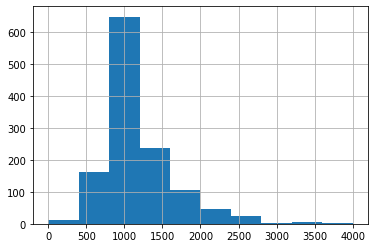

In [391]:
X_rent['area'].hist(range=(0,4000))

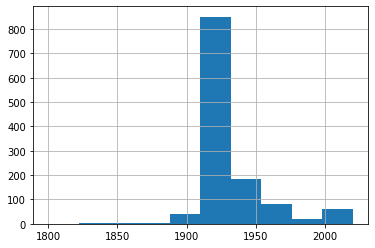

In [388]:
X_rent['year_built'].hist(range = (1800,2020))

- Prepare the target variable,price

In [243]:
y_rent = X_rent['price'].apply(lambda x: int(x.strip('$+/mo').replace(',','')))
y_rent = y_rent.values
X_rent = X_rent.drop(columns = 'price')
X = X_rent.values
y = y_rent

- Split the data into train and test set for model building

In [392]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

## 5. Modelling

### 5.1 Linear Models

In [346]:
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

#### 5.1.1 Linear Regression

In [393]:
lm = LinearRegression()
lm.fit(X_train, y_train)
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)
print('In sample R^2 is {}'.format(metrics.r2_score(y_train, y_train_pred)))
print('Out of sample R^2 is {}'.format(metrics.r2_score(y_test, y_test_pred)))

In sample R^2 is 0.6965428617398637
Out of sample R^2 is -247019467160.26135


#### 5.1.2 Ridge Regression

In [394]:
for alpha in [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]:
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_train, y_train)
    y_train_pred_ridge = ridge.predict(X_train)
    y_test_pred_ridge = ridge.predict(X_test)
    print('alpha', alpha, metrics.r2_score(y_test, y_test_pred_ridge))

alpha 1e-06 0.6234850219234774
alpha 1e-05 0.6234850357815982
alpha 0.0001 0.6234851730086317
alpha 0.001 0.6234865252982775
alpha 0.01 0.623498088228211
alpha 0.1 0.6234438014897352
alpha 1 0.6171409389971125


In [395]:
ridge = Ridge(alpha = 1e-4)
ridge.fit(X_train, y_train)
y_train_pred_ridge = ridge.predict(X_train)
y_test_pred_ridge = ridge.predict(X_test)
print('In sample R^2 is {}'.format(metrics.r2_score(y_train, y_train_pred_ridge)))
print('Out of sample R^2 is {}'.format(metrics.r2_score(y_test, y_test_pred_ridge)))

In sample R^2 is 0.696542863889695
Out of sample R^2 is 0.6234851730086317


#### 5.1.2  LASSO Regression

In [396]:
for alpha in [ 0.01, 0.1, 1,10]:
    lasso = Lasso(alpha = alpha)
    lasso.fit(X_train, y_train)
    y_train_pred_lasso = lasso.predict(X_train)
    y_test_pred_lasso = lasso.predict(X_test)
    print('alpha', alpha, metrics.r2_score(y_test, y_test_pred_lasso))

alpha 0.01 0.5961972801734444
alpha 0.1 0.60458262521746
alpha 1 0.6003354257590627
alpha 10 0.45498672867887


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1929146.544755742, tolerance: 48297.26754087513
  positive)


In [397]:
lasso = Lasso(alpha=1)
lasso.fit(X_train, y_train)
y_train_pred_lasso = lasso.predict(X_train)
y_test_pred_lasso = lasso.predict(X_test)
print('In sample R^2 is {}'.format(metrics.r2_score(y_train, y_train_pred_lasso)))
print('Out of sample R^2 is {}'.format(metrics.r2_score(y_test, y_test_pred_lasso)))

In sample R^2 is 0.6549035641722001
Out of sample R^2 is 0.6003354257590627


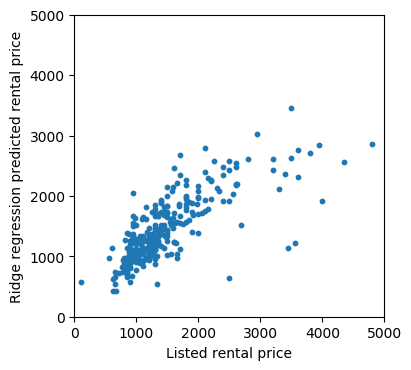

In [410]:
plt.figure(figsize=(4,4), dpi=100)
plt.scatter(y_test,y_test_pred_ridge, s = 10)
plt.xlim([0,5000])
plt.ylim([0,5000])
plt.xlabel('Listed rental price')
plt.ylabel('Ridge regression predicted rental price')
plt.show()

### 5.1 Nonlinear Models

#### 5.1.1 Tree based model

In [367]:
from sklearn.ensemble import RandomForestRegressor

In [438]:
RF = RandomForestRegressor(n_estimators=80)

In [439]:
RF.fit(X_train, y_train)
y_test_pred_RF = RF.predict(X_test)
y_train_pred_RF = RF.predict(X_train)
print('In sample R^2 is {}'.format(metrics.r2_score(y_train, y_train_pred_RF)))
print('Out of sample R^2 is {}'.format(metrics.r2_score(y_test, y_test_pred_RF)))

In sample R^2 is 0.9165114513895409
Out of sample R^2 is 0.5212073164861446


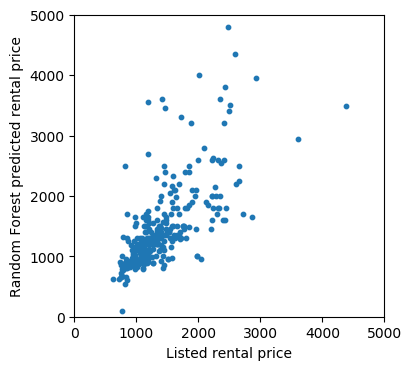

In [440]:
plt.figure(figsize=(4,4), dpi=100)
plt.scatter(y_test_pred_RF, y_test,s=10)
plt.xlim([0,5000])
plt.ylim([0,5000])
plt.xlabel('Listed rental price')
plt.ylabel('Random Forest predicted rental price')
plt.show()

- Further feature engineering will be conducted
- More data will be collected

## 6. Use developed model to predict rental price of for-sale listings
- to be done....

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
X_transform = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y)